# SMILES Instance Segmentation Dataset Explorer

This notebook explores the custom YOLO instance segmentation dataset for molecular SMILES structures. 

## 1. Setup Environment and Import Libraries

In [20]:
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from ultralytics.utils.plotting import Annotator, colors, save_one_box
from copy import deepcopy

# Set up matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100


## 2. Load Dataset Configuration

In [6]:
yaml_path = Path("./dataset.yaml")

with open(yaml_path, 'r') as f:
    dataset_config = yaml.safe_load(f)

print("Dataset Configuration:")
print("=" * 50)
for key, value in dataset_config.items():
    print(f"{key}: {value}")
print("=" * 50)

Dataset Configuration:
path: ../smiles-rendering/dataset
train: images/train
val: images/val
test: None
names: {0: 'SINGLE', 1: 'DOUBLE', 2: 'N', 3: 'O', 4: 'H'}


## 3. Load Sample Images and Labels

In [13]:
train_images_path = Path(dataset_config['path']) / dataset_config['train']
train_labels_path = Path(dataset_config['path']) / "labels" / "train"
class_names = dataset_config["names"]
class_names = list(dataset_config["names"].values())
train_images = list(train_images_path.glob("*.png"))[:10] 

print(f"Using {len(train_images)} sample images")
print("\nSample images:")
for img_path in train_images[:5]:
    print(f"  - {img_path.name}")

Using 10 sample images

Sample images:
  - 000013.png
  - 000065.png
  - 000043.png
  - 000002.png
  - 000003.png


## 4. Visualize Images with Instance Masks

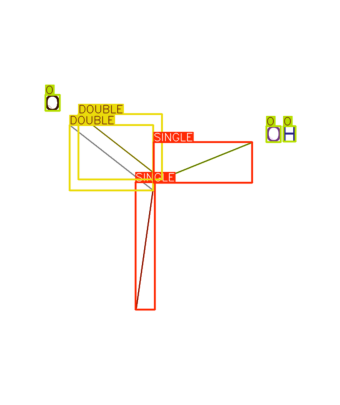

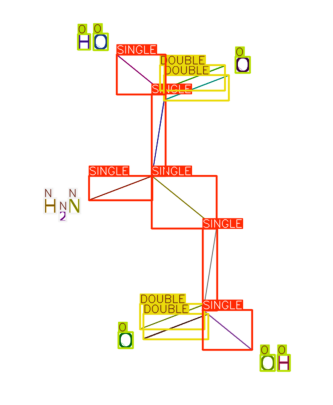

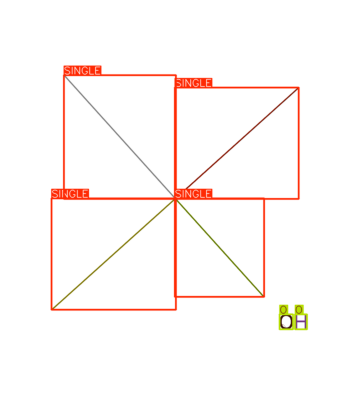

In [43]:
def parse_yolo_segmentation_label(label_file):
    instances = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 7:  # Minimum: class_id + 3 points (6 coordinates)
                print(line)
                raise ValueError(f"Invalid label format in file {label_file}")
            
            class_id = int(parts[0])
            coords = [float(x) for x in parts[1:]]
            
            # Convert flat list to list of (x, y) tuples
            points = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
            
            instances.append((class_id, points))
    
    return instances

def visualize_instance_segmentation(image_path, label_path, class_names):
    # Load image
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width = img.shape[:2]
    annotator = Annotator(
        deepcopy(img),
        example=class_names,
    )
    
    # Parse labels
    instances = parse_yolo_segmentation_label(label_path)
    instance_class_ids = [inst[0] for inst in instances]
    instance_points = [inst[1] for inst in instances]
    instance_points = [[(int(x * width), int(y * height)) for x, y in points] for points in instance_points]
    instance_masks = np.zeros((len(instances), height, width), dtype=np.uint8)

    # bounding points (instance_points) to masks (instance_masks)
    for i, points in enumerate(instance_points):
        pts = np.array(points, dtype=np.int32)
        # Ensure correct shape for OpenCV: (n_points, 1, 2)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(instance_masks[i], [pts], color=1)
    
    annotator.masks(instance_masks, colors=[colors(x, True) for x in range(len(instances))])

    for i, class_id in enumerate(instance_class_ids):
        label = class_names[class_id]
        min_x = min([p[0] for p in instance_points[i]])
        min_y = min([p[1] for p in instance_points[i]])
        max_x = max([p[0] for p in instance_points[i]])
        max_y = max([p[1] for p in instance_points[i]])
        box = (min_x, min_y, max_x, max_y)
        annotator.box_label(box, label, color=colors(class_id, True))

    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(annotator.im)
    plt.axis('off')
    
    

# Visualize first 3 samples
for img_path in train_images[:3]:
    label_path = train_labels_path / (img_path.stem + '.txt')
    if label_path.exists():
        visualize_instance_segmentation(img_path, label_path, class_names)
    else:
        print(f"Label file not found for {img_path.name}")